# 同花顺行业概念信息

In [1]:

import pandas as pd

fpath = r'../../JohnsonUtil\wencai\同花顺板块行业.xls'
thsgn = pd.read_excel(fpath)
thsgn = thsgn.set_index('股票代码')

## 查询信息

In [2]:
thsgn[:1]
thsgn.columns
thsgn.loc['300474.SZ']

股票简称                                                                  景嘉微
现价(元)                                                                  60
涨跌幅(%)                                                              -1.06
主营产品名称                  图形显控领域产品||小型专用化雷达领域产品||小型专业化雷达||图形显控模块产品||加固类产...
所属概念                    显卡;AI芯片;军民融合;雷达;深股通;人工智能;芯片设计;芯片概念;集成电路概念;军工;超...
所属同花顺行业                                                    国防军工-国防军工-军工电子
经营范围                    电子产品（不含电子出版物）、计算机软件的研究、开发、生产和销售及其相关的技术服务，集成电路设...
公司网站                                                 www.jingjiamicro.com
所属概念数量(个)                                                              19
a股流通市值 (元)2023.01.31                                          19023863000
Name: 300474.SZ, dtype: object

# Debug开启

In [3]:

# Delete Jupyter notebook root logger handler
# Set Debug
import logging
import sys

# %matplotlib inline
%matplotlib widget
# stdi, stdo, stde = sys.stdin, sys.stdout, sys.stderr
# # # reload(sys)
# # # sys.setdefaultencoding('utf-8')
# sys.stdin, sys.stdout, sys.stderr = stdi, stdo, stde

# stdout = sys.stdout
# sys.path.append('../')
# import JSONData.tdx_data_Day as tdd
# sys.stdout = stdout


mylogger = logging.getLogger()
if len(mylogger.handlers) > 0:
    for ix in mylogger.handlers:
        print("handlers:%s std:%s" % (ix.stream, sys.stdout))
else:
    print("nb not handlers")
#     mylogger.propagate = False
mylogger.setLevel(logging.ERROR)
# mylogger.setLevel(logging.DEBUG)

print("nb:", sys.stderr)
# # Create logger as usual
import nest_asyncio

nest_asyncio.apply()

nb not handlers
nb: <ipykernel.iostream.OutStream object at 0x000002D4B3FA3220>


# TDX多日数据分析

## 定义 TDX-Path

In [4]:
# encoding:utf-8
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
# InteractiveShell.ast_node_interactivity = "last_expr"

import sys

import pandas as pd
from pandas import HDFStore

stdi, stdo, stde = sys.stdin, sys.stdout, sys.stderr
# print(stdi, stdo, stde)
# reload(sys)
# sys.setdefaultencoding('utf-8')
# sys.stdin, sys.stdout, sys.stderr = stdi, stdo, stde

# print(sys.stdout,sys.stderr,sys.stderr)

# print(stdi, stdo, stde)

# sys.stdin, sys.stdout, sys.stderr = stdi, stdo, stde
# print(stdi, stdo, stde)

In [5]:
sys.path.append("../../")
import os

import JSONData.tdx_data_Day as tdd
# import win_unicode_console
from JohnsonUtil import commonTips as cct
from JSONData import sina_data

os.environ['NUMEXPR_MAX_THREADS'] = '12'

# import nest_asyncio
# nest_asyncio.apply()
# 查阅资料后发现，发现使用 jupyter notebook 环境，其连接着 IPython 内核，而 IPython 内核本身在事件循环上运行，而 asyncio 不允许嵌套其事件​​循环，因此会出现如上图的错误信息。
# nest_asyncio 作为异步操作的补丁而存在，具体内容请参考
# win_unicode_console.disable()
tdx_path = "G:\\tdx_last_df.h5"
sina_MultiD_path = "G:\\sina_MultiIndex_data.h5"
sina_d_path = "G:\\sina_data.h5"
sina_dd_path = "G:\\get_sina_all_dd.h5"
# print(stdi, stdo, stde)
sys.stdin, sys.stdout, sys.stderr = stdi, stdo, stde

# # 显示所有列
pd.set_option("display.max_columns", None)
# # 显示所有行
# pd.set_option('display.max_rows', None)
# # 设置 value 的显示长度为 100，默认为 50
# pd.set_option('max_colwidth',100)
# pd.set_option?
# df.columns.tolist()

In [6]:
cct.code_to_symbol_ths('000002')

'000002.SZ'

### 功能定义

In [7]:
def apply_col_toint(df, col=None):
    if col is None:
        co2int = ['boll', 'op', 'ratio', 'fib', 'fibl', 'df2']
    # co2int.extend([co for co in df.columns.tolist()
    #                if co.startswith('perc') and co.endswith('d')])
        co2int.extend(['top10', 'topR'])
    else:
        co2int = col
    co2int = [inx for inx in co2int if inx in df.columns]

    for co in co2int:
        df[co] = df[co].astype(int)

    return df


def readHdf5(fpath, root=None):
    store = pd.HDFStore(fpath, "r")
    print(store.keys())
    if root is None:
        root = store.keys()[0].replace("/", "")
    df = store[root]
    df = apply_col_toint(df)
    store.close()
    return df


def write_code_to_blk(codew, blk='090'):
    block_path = tdd.get_tdx_dir_blocknew() + '%s.blk' % (blk)
    write_blk = 'n'
    write_blk = cct.cct_raw_input("write blk [Y] or [N]:")
    if write_blk == 'y' or write_blk == 'Y':
        hdf5_wri = cct.cct_raw_input(
            "Rewrite code [Y] or append [N](defalut:N):")
        if hdf5_wri == 'y' or hdf5_wri == 'Y':
            append_status = False
        else:
            append_status = True
        if len(codew) > 3:
            cct.write_to_blocknew(block_path, codew, append_status,
                                  doubleFile=False, keep_last=0)
            ("write:%s block_path:%s" % (len(codew), block_path))
        else:
            ("write error:%s block_path:%s" % (len(codew), block_path))


def show_tdx_data(df, codelist=None, market_value='3', col=None):

    columns_ = [
        "name", "category", "close", "percent",'volra', 'topR', "lastp1d", "ma5dcum",
        "ma20d", "fib", "fibl", "ra", "ral", "df2", "per1d", "hmax", "lmin",
        "per%sd" % (market_value),
        "perc%sd" % (market_value)]
    if isinstance(df, pd.Series):
        columns_ = [co for co in columns_ if co in df.index]
    else:
        columns_ = [co for co in columns_ if co in df.columns]
    if col is not None:
        columns_.insert(4, col)

    if codelist is None:
        if isinstance(df, pd.Series):
            # print("Count:1")
            temp = df.loc[columns_]
        else:
            print("Count:%s %s" % (df.shape))
            temp = df.loc[:, columns_]
    else:
        temp = df.loc[[x for x in codelist if x in df.index], columns_]
    return temp


def compute_perd_value(df, market_value=3, col="per"):

    # if market_value == None or market_value < "2":
    #     market_value = 3
    # if market_value > 1 and len(df[ df["%s%sd" % (col, market_value)] > 2])   :
    market_value = str(market_value)
    if market_value > str(1):
        temp = df[
            df.columns[
                (df.columns >= "%s1d" % (col))
                & (df.columns <= "%s%sd" % (col, market_value))
            ]
        ]

        df['%s%sd' % (col, market_value)] = temp.T.sum().apply(
            lambda x: round(x, 1))
    else:
        print("market_value <= 1,No Compute")

    return df


def clean_688(df):
    df = df[(~df.index.str.contains("688"))]
    return df


from collections import Counter, OrderedDict


def counterCategory(df):
    top5 = dict()
    if len(df) > 0:
        categoryl = df.category[:20].tolist()
        dicSort = []
        for i in categoryl:
            if isinstance(i, str):
                # dicSort.extend([ co.decode('utf8') for co in i.split(';')])
                dicSort.extend(i.split(';'))
                # cate_list = i.split(';')
                # for co in cate_list:
                #     dicSort.append(to_str(co))
        topSort = Counter(dicSort)
        top5 = OrderedDict(topSort.most_common(5))
        # for i in top5.keys():
        # print(i, top5[i]),
        # print('')
    # for i in top5.keys():
    #     # print(u"板块:%s %s " % (i.decode('utf8'), (topSort[i]))),
    #     # print(u"板块:%s count:%s" % (i, (topSort[i]))),
    #     print(i, (topSort[i]))

    return top5


def get_runtime_percent(df, perd=None):
    if "percent" not in df.columns and "lastp1d" in df.columns:
        # print('init percent')
        df = df.fillna(0)
        df['percent'] = list(
            map(
                lambda x, y, z: round((x - y) / y * 100, 1)
                if x != y else round((x - z) / z * 100, 1),
                df.close, df.lastp1d, df.lastp2d))
        # df['percent'] = df.apply(lambda x: round((x.close - x.lastp1d) /(x.lastp1d) * 100, 1),axis=1)
    # else:
    #     print('Percent in columns')
    if not perd is None:
        df[perd] = list(map(lambda x, y: round((x + y), 1)
                            if int(y) > 0 else 0, df.perd, df.percent))
    return df


def get_realtime_ratio(df, market='all'):
    if 'ratio' in df.columns:
        df.drop('ratio', axis=1, inplace=True)
    ratio_df = tdd.getSinaJsondf(market)
    df = cct.combine_dataFrame(
        df, ratio_df.ratio, col=None, compare=None, append=False, clean=False)
    return df


def get_ths_info(code):
    code = cct.code_to_symbol_ths(code)
    return thsgn.loc[code]

### 还原Cell输出信息

In [8]:
# sys.stdin, sys.stdout, sys.stderr = stdi, stdo, stde
# print(stdi, stdo, stde)

## 初始化 hdf5的tdx数据

In [9]:

market_value = "3"
df = readHdf5(tdx_path)
df = tdd.get_sina_datadf_cnamedf(df.index.tolist(), df)
df = compute_perd_value(df, market_value, "perc")
df = compute_perd_value(df, market_value, "per")

df = get_realtime_ratio(df)
# df=get_runtime_percent(df)

df = get_runtime_percent(df, "per%sd" % (market_value))

# filter 科创
df = clean_688(df)

df.shape
df[-1:].percent
df[~(df.last6vol > 0)][:10].last6vol
df.ratio[-2:]

['/low_d_60_y_all', '/low_w_180_y_all']


(4392, 119)

code
603603    0.5
Name: percent, dtype: float64

Series([], Name: last6vol, dtype: float64)

code
600136    1.5
603603    1.4
Name: ratio, dtype: float64

## 个股数据查看

In [10]:
df.ma203d[:1]
# df.loc['003042'].loc[["category", "close"]]

code
999999    3271.83
Name: ma203d, dtype: float64

In [11]:
show_tdx_data(df.loc['003042'])
get_ths_info('003042')

name                  中农联合
category    新股与次新股 ;核准制次新股
close                23.64
percent                1.9
topR                     0
lastp1d              23.21
ma5dcum               25.2
ma20d                 25.7
fib                      2
fibl                     1
ra                    10.0
ral                  -27.2
df2                      5
per1d                 -2.8
hmax                  30.0
lmin                 23.82
per3d                 -0.9
perc3d                -2.2
Name: 003042, dtype: object

股票简称                                                                 中农联合
现价(元)                                                               26.24
涨跌幅(%)                                                               0.92
主营产品名称                  吡虫啉||啶虫脒||烯啶虫胺||哒螨灵||低毒农药原药及其中间体||杀虫剂||杀菌剂||除草...
所属概念                                                  草甘膦;乡村振兴;中俄贸易概念;供销社
所属同花顺行业                                                      基础化工-化学制品-农药
经营范围                    生物、化学农药、化工产品及仪器仪表的技术开发、技术转让、技术咨询服务；农药（不含化学危险品）...
公司网站                                                       www.sdznlh.com
所属概念数量(个)                                                               4
a股流通市值 (元)2023.01.31                                           1787252200
Name: 003042.SZ, dtype: object

In [12]:
# df[(df.close > df.ma20d * 0.99) & (df.close < df.ma20d * 1.05)]

def filter_ma_range_df(df, ma='20', days='3'):
    dd = []
    for da in range(int(days), 0, -1):
        # print(da, ma)
        # df1 = df[ (df['lastp%sd'%(da)] > df['ma%s%sd'%(ma,da)]) & (df['lastp%sd'%(days)] < df['ma%s%sd'%(ma,da)] * 1.1)]
        df1 = df[(df['lastp%sd' % (da)] > df['ma%s%sd' % (ma, da)] * 0.99)]
        if da == days:
            dd = df1.index.tolist()
        else:
            dd = [x for x in dd if x in df1.index]

    return [x for x in set(dd)]


def get_union_list(maind, subd):
    # 筛选Main存在后切在新Sub出现
    return [x for x in maind if x in subd]

### 新农联合筛选

In [13]:
code_fs = '003042'
# show_tdx_data(df.loc['003042'])
# get_ths_info('003042')

df_f_t = df[(df.fib < 30) & (df.fibl > 6) & (df.df2 > 2) & (df.ral < -15) &
            (df.close >= df.ma5dcum) & (df.perc3d > 1.1) & (df.lastv1d > df.lastv2d) & (df.close > df.ma5d) ]

df_f_t.shape
# df_f_t.loc[code_fs][:1]
show_tdx_data(df_f_t)[:5]


(5, 119)

Count:5 119


,name,category,close,percent,topR,lastp1d,ma5dcum,ma20d,fib,fibl,ra,ral,df2,per1d,hmax,lmin,per3d,perc3d
code,,,,,,,,,,,,,,,,,,
300393,中来股份,新能源;光伏概念;太阳能,15.18,0.7,0,15.07,15.0,15.30,9,9,0.0,-23.5,3,1.5,19.30,14.26,0.0,2.9
300481,濮阳惠成,新材料概念;OLED,26.65,2.8,0,25.92,26.3,26.81,9,9,4.0,-22.9,3,-0.7,32.50,25.30,2.1,1.8
603583,捷昌驱动,新股与次新股 ;白马股,24.51,0.4,0,24.41,24.5,25.57,9,9,0.0,-21.8,4,0.4,31.08,23.33,0.0,1.9
002623,亚玛顿,新能源;光伏玻璃;太阳能,30.78,1.5,0,30.33,30.3,30.89,9,9,4.0,-20.1,3,-0.7,36.96,29.29,0.8,2.9
300648,星云股份,锂电池;高送转;锂电设备,37.48,2.3,0,36.63,36.9,37.48,9,9,2.0,-22.2,6,-2.0,46.00,35.12,0.3,3.0


#### 写入069

In [14]:
# write_code_to_blk(df_f_t.index, '069')

In [15]:
df_ma26d = filter_ma_range_df(df, ma=20, days=5)
# 连续3日在生命线上
# df_ma26d = df[(df.fibl > 1) & (df.ra > 5)]
len(df_ma26d)
df_ma5d = filter_ma_range_df(df, ma=5, days=5)

# 连续3日在生命线上
len(df_ma5d)
df_x = get_union_list(df_ma26d, df_ma5d)
df_5dx_20d = get_union_list(df_x, df[df.ma5d < df.ma20d].index)

show_tdx_data(df.loc[df_5dx_20d])

1296

814

Count:9 119


,name,category,close,percent,topR,lastp1d,ma5dcum,ma20d,fib,fibl,ra,ral,df2,per1d,hmax,lmin,per3d,perc3d
code,,,,,,,,,,,,,,,,,,
600089,特变电工,低碳;国家科技大会;分布式发电,21.93,0.6,0,21.81,21.7,21.70,60,4,0.0,-4.1,0,0.3,22.48,21.23,0.0,3.1
601006,大秦铁路,铁路基建;MSCI概念;营改增,7.24,0.8,0,7.18,7.3,7.24,52,1,6.0,-4.8,0,0.0,7.31,7.14,0.0,0.0
601330,绿色动力,新股与次新股 ;沪股通,7.34,2.8,0,7.14,7.1,7.16,59,9,3.0,-3.0,0,0.6,7.29,7.03,3.4,2.9
002673,西部证券,MSCI概念;参股新三板;地方,6.40,0.3,0,6.40,6.4,6.43,58,9,2.0,-8.2,0,0.3,6.86,6.27,0.0,3.0
601229,上海银行,MSCI概念;融资融券;沪股通,6.02,0.3,0,6.00,6.0,6.04,59,1,3.0,-3.2,0,0.2,6.10,5.98,0.0,2.0
600177,雅戈尔,MSCI概念;参股保险;电子商,6.56,0.5,0,6.53,6.5,6.54,59,1,5.0,-1.7,0,0.3,6.62,6.47,0.0,2.0
003041,真爱美家,新股与次新股 ;核准制次新股,19.83,0.6,0,19.71,19.8,19.81,53,1,5.0,-3.9,0,0.2,20.34,19.43,0.0,2.0
999999,0,0,0.00,-100.0,0,3261.25,3258.3,3266.34,60,1,5.0,-2.4,0,0.5,3328.39,3229.58,0.0,3.1
300555,ST路通,农村电商;乡村振兴,6.69,0.1,0,6.68,6.6,6.65,42,3,0.0,-4.0,0,-0.6,6.85,6.38,0.0,3.1


In [16]:
df.loc[["603068", '601377', '000725'],
       ["date", "name", "category", "percent", "close", "lastp1d", "ma5d",
        "ma5dcum", "ma20d", "fib", "fibl", "df2", "per1d", "hmax", "lmin",
        "ra", "ral", "vcall", "vcra", "vchange", "lvol", 'lv', 'lowvol',
        'last6vol', 'per%sd' % (market_value),
        'perc%sd' % (market_value),
        'perc4d']][: 3]

,date,name,category,percent,close,lastp1d,ma5d,ma5dcum,ma20d,fib,fibl,df2,per1d,hmax,lmin,ra,ral,vcall,vcra,vchange,lvol,lv,lowvol,last6vol,per3d,perc3d,perc4d
code,,,,,,,,,,,,,,,,,,,,,,,,,,,
603068,2023-01-12,博通集成,新股与次新股,-0.6,33.83,34.05,33.75,33.9,33.49,58,2,0,1.2,34.50,32.72,5.0,-3.3,223.2,2.0,75.4,4728600.0,1605500.0,2027492.0,2695700.0,0.0,3.0,0.9
601377,2023-01-03,兴业证券,参股新三板;MSCI概念;融资,0.5,6.12,6.09,6.14,6.1,6.19,58,1,0,0.0,7.03,6.05,3.0,-14.2,317.7,3.0,12.3,50663581.0,21547268.0,78438797.0,32509254.0,0.0,1.9,1.0
000725,2022-12-29,京东方Ａ,国开行;物联网;OLED,-0.9,4.39,4.43,4.41,4.3,4.24,60,9,0,0.9,4.26,4.13,2.0,-2.4,299.4,5.0,9.9,338593302.0,107932196.0,146636206.0,308059732.0,0.0,3.1,0.9


In [17]:

sort_key2 = "per%sd" % (market_value)
df = df.sort_values(
    by=["perc%sd" % (market_value), sort_key2, "fib"], ascending=[0, 0, 1]
)
show_tdx_data(df)[: 5]

show_tdx_data(df)[-5:]
# df = df.sort_values(by=['perc%sd'%(market_value), 'per%sd'%(market_value),'fib'],ascending=[0,0,1])

Count:4392 119


,name,category,close,percent,topR,lastp1d,ma5dcum,ma20d,fib,fibl,ra,ral,df2,per1d,hmax,lmin,per3d,perc3d
code,,,,,,,,,,,,,,,,,,
601116,三江购物,股权转让;阿里巴巴概念;沪股通,14.69,6.8,2,13.75,10.4,10.55,9,9,0.0,10.0,2,10.0,11.35,9.80,16.8,3.3
600306,*ST商城,微信概念;车联网;新零售,9.66,6.6,1,9.06,8.5,8.57,22,4,0.0,-4.6,3,0.4,9.16,8.02,7.0,3.3
000860,顺鑫农业,强麦;猪肉收储;普麦,35.91,3.8,0,34.58,31.3,32.41,42,9,0.0,-3.6,8,2.6,35.08,29.81,6.4,3.3
601965,中国汽研,央企国资改革;有轨电车;中字头,24.46,2.8,0,23.79,22.7,23.60,46,9,0.0,-9.3,13,1.1,25.89,21.63,3.9,3.3
000525,ST红太阳,吡啶;农村电商;草甘膦,10.09,2.0,1,9.89,9.5,10.12,3,3,0.0,-23.7,0,0.5,12.88,8.88,2.5,3.3


Count:4392 119


,name,category,close,percent,topR,lastp1d,ma5dcum,ma20d,fib,fibl,ra,ral,df2,per1d,hmax,lmin,per3d,perc3d
code,,,,,,,,,,,,,,,,,,
600532,*ST未来,蜱虫;网络游戏;股权转让,8.02,-5.0,-4,8.44,11.1,11.50,45,1,10.0,-39.7,14,-5.0,13.89,8.88,0.0,-3.3
003029,吉大正元,华为概念 ;新股与次新股 ;核,33.09,-0.6,0,33.30,38.2,37.11,59,1,7.0,-23.3,2,-2.5,41.06,33.98,0.0,-3.3
002231,奥维通信,电子信息;振兴东北;股权转让,7.38,0.7,0,7.33,8.2,8.39,60,1,4.0,-32.1,0,-4.8,9.92,7.59,0.0,-3.3
300742,越博动力,电机电控;新能源汽车,8.65,1.8,-1,8.50,10.2,10.70,2,1,6.0,-45.1,4,-2.5,14.83,8.72,-0.7,-3.3
300970,华绿生物,融资融券 ;转融券标的 ;新股,19.29,1.1,0,19.08,21.0,20.86,51,1,7.0,-18.7,6,-2.6,22.78,19.45,-1.5,-3.3


## filter 20D 涨幅榜 

In [18]:
# df = df[(df['close'] > df['ma20d'] * 0.98) & (df['close'] < df['ma20d'] * 1.03)]
f20df = df[(df['close'] > df['ma20d'] * 0.98)
           & (df['df2'] > 0) & (df['lastp1d'] > df['ma5d']) & (df['lasth1d'] >= df['lasth2d']) ]

f20df.shape
show_tdx_data(f20df)[: 3]
show_tdx_data(f20df)[-3:]

(299, 119)

Count:299 119


,name,category,close,percent,topR,lastp1d,ma5dcum,ma20d,fib,fibl,ra,ral,df2,per1d,hmax,lmin,per3d,perc3d
code,,,,,,,,,,,,,,,,,,
601116,三江购物,股权转让;阿里巴巴概念;沪股通,14.69,6.8,2,13.75,10.4,10.55,9,9,0.0,10.0,2,10.0,11.35,9.80,16.8,3.3
600306,*ST商城,微信概念;车联网;新零售,9.66,6.6,1,9.06,8.5,8.57,22,4,0.0,-4.6,3,0.4,9.16,8.02,7.0,3.3
000860,顺鑫农业,强麦;猪肉收储;普麦,35.91,3.8,0,34.58,31.3,32.41,42,9,0.0,-3.6,8,2.6,35.08,29.81,6.4,3.3


Count:299 119


,name,category,close,percent,topR,lastp1d,ma5dcum,ma20d,fib,fibl,ra,ral,df2,per1d,hmax,lmin,per3d,perc3d
code,,,,,,,,,,,,,,,,,,
600282,南钢股份,人民币贬值概念;参股新三板;债,3.86,0.3,0,3.85,3.8,3.90,60,8,0.0,-7.2,7,1.3,4.06,3.78,0.0,0.9
603136,天目湖,新股与次新股,30.21,-1.5,0,30.66,29.9,30.47,54,1,0.0,-8.3,2,5.7,33.03,28.70,0.0,0.0
002213,大为股份,,14.96,-0.3,0,15.00,14.3,14.59,2,1,0.0,-18.7,1,9.2,17.46,13.69,0.0,-0.1


In [19]:

sort_key2 = "per%sd" % (market_value)

f20df = f20df.sort_values(
    by=[sort_key2, "perc%sd" % (market_value), "fib"], ascending=[0, 0, 1]
)
f20df.shape
show_tdx_data(f20df)[: 5]

show_tdx_data(f20df)[-5:]


# df.loc[:, ["name"]].T

(299, 119)

Count:299 119


,name,category,close,percent,topR,lastp1d,ma5dcum,ma20d,fib,fibl,ra,ral,df2,per1d,hmax,lmin,per3d,perc3d
code,,,,,,,,,,,,,,,,,,
600975,新五丰,地方国资改革;湖南国资改革;家,10.85,8.9,1,9.96,8.5,8.29,59,8,0.0,2.2,8,9.8,9.06,7.98,18.7,3.2
603477,巨星农牧,新股与次新股,30.64,10.0,0,27.85,24.8,25.04,52,6,0.0,-0.5,3,7.0,27.67,23.31,17.0,3.1
601116,三江购物,股权转让;阿里巴巴概念;沪股通,14.69,6.8,2,13.75,10.4,10.55,9,9,0.0,10.0,2,10.0,11.35,9.80,16.8,3.3
603066,音飞储存,双十一;智能物流;并购重组,12.91,10.0,0,11.74,10.9,11.14,60,9,0.0,-13.7,5,5.3,12.70,10.45,15.3,3.1
002536,飞龙股份,特斯拉,11.34,5.0,1,10.80,9.3,9.33,60,9,0.0,-1.8,8,10.0,10.47,8.57,15.0,3.1


Count:299 119


,name,category,close,percent,topR,lastp1d,ma5dcum,ma20d,fib,fibl,ra,ral,df2,per1d,hmax,lmin,per3d,perc3d
code,,,,,,,,,,,,,,,,,,
002213,大为股份,,14.96,-0.3,0,15.00,14.3,14.59,2,1,0.0,-18.7,1,9.2,17.46,13.69,0.0,-0.1
603179,新泉股份,汽车制造概念;白马股,43.76,2.0,0,42.91,39.1,39.30,14,9,0.0,-6.2,3,-2.5,44.90,35.81,-0.5,3.2
300567,精测电子,苹果概念;OLED;高送转,64.82,1.0,0,64.18,64.8,65.10,58,3,2.0,-6.5,4,-2.3,67.79,61.00,-1.3,1.0
300655,晶瑞电材,新材料概念;新股与次新股;高送,23.61,1.3,1,23.30,20.2,19.24,60,7,0.0,-6.6,14,-2.9,18.45,18.18,-1.6,3.1
002493,荣盛石化,PTA;油品改革;PTA涨价,15.20,2.1,2,14.89,12.2,12.68,51,9,0.0,-4.7,3,-4.7,13.98,11.32,-2.6,3.1


In [20]:
# code = ["000725"]
# f20df.loc[code,
#           ["name", "close", "percent", "lastp1d", "ma5dcum", "ma20d", "fib",
#            "fibl", "ra", "df2", "per1d", "hmax", "lmin", "per%sd" %
#            (market_value),
#               "perc%sd" % (market_value)]]

## Write code to blk 

In [21]:


# codew = df.index.tolist()
# write_code_to_blk(codew)

# TDX参数数据信息

In [22]:
# code = '002670'
# tdf = tdd.get_tdx_Exp_day_to_df(code, dl=60).sort_index(ascending=True)
# tdf.dropna(inplace=True)
# tdf.loc[:, ["close", "ma5d", "ma10d",
#             "ma20d", "upper", "lower", "hmax", "lmin"]].plot()
# tdf = compute_perd_value(tdf, market_value, "per")

# 实时sina_MultiIndex 分析

## 初始化当日Multi

In [23]:
# ohlc_dict = {'open': 'first',
#              'high': 'max',
#              'low': 'min',
#              'close': 'last'}

ohlc_dict = {
    'volume': 'sum',
    'high': 'max',
    'low': 'min',
    'close': 'last'}


def minmax_norm(df):
    return ((df - df.min()) / (df.max() - df.min())).apply(lambda x: round(x, 2))

# def apply_round(df):
#     return df.apply(lambda x:round(x,2))


import pandas as pd
from pandas import HDFStore

# sina_MultiD_path = "G:\\sina_MultiIndex_data.h5"
# freq='30T'
# startime = '09:25:00'
# endtime = '15:01:00'
# def readHdf5(fpath, root=None):
#     store = pd.HDFStore(fpath, "r")
#     print((store.keys()))
#     if root is None:
#         root = list(store.keys())[0].replace("/", "")
#     df = store[root]
#     store.close()
#     return df

h5 = readHdf5(sina_MultiD_path)
print(sina_MultiD_path)
h5.shape
# h5[:1]
code_muti = '600519'
h5.loc[code_muti][:2]
h5.loc[code_muti][-1:]

['/all_10']
G:\sina_MultiIndex_data.h5


(654651, 6)

,close,high,low,llastp,volume,lastbuy
ticktime,,,,,,
2023-03-31 09:25:44,1825.00,1825.0,1825.0,1800.0,70681,1825.0
2023-03-31 09:30:36,1832.87,1833.0,1825.0,1800.0,207939,1825.0


,close,high,low,llastp,volume,lastbuy
ticktime,,,,,,
2023-03-31 10:18:24,1826.8,1848.0,1821.4,1800.0,1513881,1827.0


## Now freq = 'D' 总量占比

In [24]:
# h5_ohlc = h5.loc[code_muti, ['close', 'volume']]
# h5_ohlc_Day = h5_ohlc.groupby(pd.Grouper(
#     freq='1D', closed='right', label='right')).agg(
#     ohlc_dict).dropna()
# freq = '30T'
freq = 'D'
startime = '09:25:00'
endtime = '15:01:00'

time_ratio = cct.get_work_time_ratio()

run_col = ['close', 'volume']
mdf = cct.get_limit_multiIndex_freq(
    h5, freq=freq.upper(),
    col=run_col, start=startime, end=endtime, code=None)
allvol = mdf.volume.sum()
allvol / 1000 / 1000 / 1000
mdf.loc['002195'].volume / mdf.loc['600705'].volume
ndf = mdf.copy()
ndf.info(show_counts=True)
ndf.describe()

2046.697518652

ticktime
2023-04-01    4.758557
Freq: D, Name: volume, dtype: float64

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4916 entries, ('000001', Timestamp('2023-04-01 00:00:00', freq='D')) to ('689009', Timestamp('2023-04-01 00:00:00', freq='D'))
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   4916 non-null   float64
 1   volume  4916 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 258.8+ KB


,close,volume
count,4916.000000,4.916000e+03
mean,28.562314,4.163339e+08
std,207.356234,1.110367e+09
min,0.000000,0.000000e+00
25%,6.830114,5.176119e+07
50%,13.497576,1.411292e+08
75%,26.088447,3.616192e+08
max,11707.040000,2.930145e+10


### TDX filter Vol and fibl

####  9日交易量nvol_idx 

In [25]:
# 9日交易量Mean
temp = df[df.columns[((df.columns >= 'lastv1d') & (df.columns <= 'lastv9d'))]]
temp.shape, temp.columns
temp['volmean'] = temp.mean(axis=1)
# temp[:1]
temp['volnow'] = round(temp['lastv1d'] / temp['volmean'], 2)
nvol_idx = temp.sort_values(by=['volnow'], ascending=[0])
# nvol_idx.index
nvol_idx.loc[:, ['volnow']].T[:20]
df = get_realtime_ratio(df)

show_tdx_data(df, nvol_idx.index[:20], col='ratio').T
nvol_idx.shape

((4392, 9),
 Index(['lastv1d', 'lastv2d', 'lastv3d', 'lastv4d', 'lastv5d', 'lastv6d',
        'lastv7d', 'lastv8d', 'lastv9d'],
       dtype='object'))

code,002089,002493,000593,300985,002457,601116,603109,301118,300302,000620,002491,002213,603733,301216,600838,600306,002524,603356,603300,300829,301363,000333,300575,600444,002420,002561,000404,600860,601236,300471,000428,003020,003013,600502,002595,300857,001206,002251,002153,000045,002095,605098,000541,601216,002199,002787,603399,300387,001896,600693,605358,600290,000833,603829,600573,300841,601799,300957,002611,300650,601857,603132,603730,605188,300356,603937,000759,002586,002548,300188,603333,000636,301086,603315,002840,603978,600687,002286,605118,601717,002365,605060,300082,002186,605089,301020,603378,300582,000785,300295,601086,301300,002461,000088,002264,001223,600335,002685,300420,603066,605218,000936,300046,301366,300485,600598,603136,300223,600234,000525,000550,300282,600060,002499,603708,600997,600876,603833,002316,603707,600029,300943,600331,603338,000697,300950,301101,002791,600115,603787,000937,002596,601225,605376,603755,601865,605081,301073,000669,002183,300108,600054,600462,300991,301185,002187,300228,600226,301326,603080,002480,603211,603970,600985,000048,600078,601658,301367,000597,301336,600609,301121,300766,300268,600225,002039,300994,301205,301263,605365,002639,002626,603933,603986,300077,603028,600382,603967,001309,603681,600094,600428,300386,600238,002122,600241,300449,002594,002271,002404,300967,600900,600839,000610,300007,603355,002508,601007,002336,603151,300892,603856,000721,002015,300926,300381,300614,300427,002007,002076,300911,300839,002838,300545,301398,600790,301070,603076,603535,000021,000523,601811,600690,000692,000016,002959,300437,300894,002759,600201,600218,001696,603365,002033,301369,301113,002537,000056,603477,300805,301060,300042,603637,601326,300430,002072,000651,600703,000719,002130,002505,002112,601568,000978,300351,301308,301116,301319,603199,601619,002184,603053,601628,300783,300856,300435,000633,600386,603416,601858,000586,300825,600200,601898,300327,000571,002535,002730,301227,601111,300855,600151,002956,300659,603896,600859,000425,000063,600123,002569,002049,600370,300832,600110,002820,002557,000729,600889,600935,300671,002677,605580,300447,601966,301077,000039,301258,300157,002957,000089,002192,000869,000430,600866,601038,600854,300683,002208,600348,603816,300699,605277,300913,002589,002054,600132,300568,300322,603888,603803,002876,600488,601801,603195,300602,601666,000783,300757,000933,603156,000656,300715,300334,003041,603360,301380,600725,002818,300638,000961,002485,600938,600508,300119,605108,603209,002032,605369,300166,000667,001215,600149,002653,301285,002052,000150,600628,300323,601021,000921,000524,600258,002918,603995,605300,002102,301312,300005,002115,002177,301226,600061,300391,600073,002952,300859,001234,000566,002383,603602,600841,300248,603709,603918,600059,002559,603657,002263,600282,300819,300273,002778,600138,002134,300192,002734,001205,002567,601128,300553,002334,600793,300116,002942,002243,300657,002242,000723,300180,600600,600638,000537,000888,300737,600601,301069,600022,000911,300902,603507,001227,300256,300032,002268,603801,603868,603059,605133,600582,603608,600971,002649,603100,603067,300091,300478,605368,600182,301220,300806,001338,002928,001333,600757,603188,002597,600397,600766,603515,300493,000565,600765,000046,003021,600805,601101,603931,601108,000821,001203,002810,002176,300854,300165,603605,002612,002216,600420,300446,002229,000786,002141,601360,600740,000985,003016,600827,600732,603633,002206,600116,600722,000158,603130,002086,002210,000668,002310,601162,601888,001323,001322,600369,301168,600064,603055,300129,603979,000627,603617,603181,300443,000635,301090,000983,600256,000818,600207,002256,000059,601699,603533,600007,300751,603043,603389,301017,603191,600812,002783,600770,000501,300824,603823,603711,300261,600754,600188,603636,000156,300986,002129,605166,600010,600887,300605,002059,600189,002118,600066,600667,300929,002099,000005,002701,600016,002211,603208,300964,300812,002418,601126,600759,601000,300939,600857,601066,603060,600098,000066,60305

code,002089,002493,000593,300985,002457,601116,603109,301118,300302,000620,002491,002213,603733,301216,600838,600306,002524,603356,603300,300829
name,*ST新海,荣盛石化,德龙汇能,致远新能,青龙管业,三江购物,神驰机电,恒光股份,同有科技,新华联,通鼎互联,大为股份,仙鹤股份,万凯新材,上海九百,*ST商城,光正眼科,华菱精工,华铁应急,金丹科技
category,云服务;军民融合;华为概念,PTA;油品改革;PTA涨价,供气;西气东输;雄安新区,融资融券 ;转融券标的 ;注册,南水北调;参股民营银行;地下管,股权转让;阿里巴巴概念;沪股通,新股与次新股 ;非科创次新股,融资融券 ;转融券标的 ;三氯,数据存储;云计算;去IOE,新型城镇化;参股民营银行;北京,移动互联网;参股新三板;大数据,,新股与次新股;双胶纸,融资融券 ;转融券标的 ;注册,新零售;上海国资改革;地方国资,微信概念;车联网;新零售,钢结构;一带一路;西部开发,电梯概念;新股与次新股,融资租赁;京津冀一体化;金改,新股与次新股 ;非科创次新股
close,0.95,15.2,7.26,28.46,8.73,14.69,16.7,33.49,10.16,2.98,6.23,14.96,25.45,28.02,6.7,9.66,7.39,12.23,8.6,24.79
percent,-5.9,2.1,-3.3,-5.5,-0.7,6.8,-0.1,-2.1,-7.0,-2.0,10.1,-0.3,-5.3,-1.2,-1.3,6.6,-0.3,0.2,2.9,2.6
ratio,3.6,1.5,2.1,11.0,2.4,6.7,3.2,3.3,11.9,1.0,5.7,5.8,0.3,1.2,0.8,1.7,NaN,NaN,1.1,2.6
topR,-9,2,0,0,1,2,1,0,0,1,0,0,0,0,0,1,0,-1,0,0
lastp1d,1.01,14.89,7.51,30.11,8.79,13.75,16.71,34.22,10.92,3.04,5.66,15.0,25.45,28.35,6.79,9.06,7.41,12.21,8.36,24.17
ma5dcum,1.3,12.2,7.4,23.4,8.7,10.4,15.2,31.6,9.0,2.9,5.4,14.3,27.8,29.1,6.6,8.5,7.1,13.9,7.9,22.9
ma20d,1.57,12.68,7.46,24.43,8.7,10.55,15.39,31.93,8.92,2.93,5.33,14.59,27.91,29.17,6.67,8.57,7.08,14.0,8.01,22.95
fib,2,51,9,59,59,9,60,59,60,2,60,2,2,60,12,22,13,2,60,51


(4392, 11)

In [26]:
df.shape
df.loc['002197'].per3d

(4392, 119)

0.0

##### TDX Filter Vol 写入090

write_code_to_blk(vdf.index.tolist())

#### 连续放量4日v_idx

In [27]:
# print("连续增量:%s"%(v_idx.shape))
v4_idx = nvol_idx[(nvol_idx.lastv1d > nvol_idx.lastv2d) &
                  (nvol_idx.lastv2d > nvol_idx.lastv3d) &
                  (nvol_idx.lastv3d > nvol_idx.lastv4d)]
v4_idx.shape
v4_idx.loc[:, ['volnow']][:20].T
df = get_realtime_ratio(df)
show_tdx_data(df, v4_idx.index[:10], col='ratio')

(59, 11)

code,002089,301118,002491,002524,600693,605358,600290,603730,600687,301020,603378,603136,600054,600985,600241,601007,002076,301398,601811,300042
volnow,8.4,3.58,3.44,3.22,2.53,2.53,2.52,2.38,2.3,2.26,2.25,2.13,1.98,1.93,1.82,1.79,1.76,1.75,1.74,1.71


,name,category,close,percent,ratio,topR,lastp1d,ma5dcum,ma20d,fib,fibl,ra,ral,df2,per1d,hmax,lmin,per3d,perc3d
code,,,,,,,,,,,,,,,,,,,
002089,*ST新海,云服务;军民融合;华为概念,0.95,-5.9,3.6,-9,1.01,1.3,1.57,2,2,10.0,-62.0,0,1.0,2.56,1.00,0.0,-2.1
301118,恒光股份,融资融券 ;转融券标的 ;三氯,33.49,-2.1,3.3,0,34.22,31.6,31.93,59,9,0.0,0.2,0,4.2,34.12,30.62,0.0,3.3
002491,通鼎互联,移动互联网;参股新三板;大数据,6.23,10.1,5.7,0,5.66,5.4,5.33,60,8,0.0,-7.4,2,-7.4,5.27,5.10,2.7,3.1
002524,光正眼科,钢结构;一带一路;西部开发,7.39,-0.3,NaN,0,7.41,7.1,7.08,13,9,0.0,-4.9,0,-4.9,7.70,6.81,0.0,3.1
600693,东百集团,平潭免税区;新零售;沪股通,4.21,-0.5,0.7,0,4.23,4.1,4.16,9,9,0.0,-14.7,0,1.2,4.89,4.02,0.0,2.1
605358,立昂微,核准制次新股 ;新股与次新股,53.02,-0.3,2.5,1,53.20,49.5,48.16,58,2,0.0,1.6,1,1.6,49.30,47.38,0.0,3.1
600290,ST华仪,低碳;智能电网;新能源,1.85,-0.5,0.7,0,1.86,2.1,2.10,2,1,3.0,-18.8,0,-5.1,2.28,1.94,0.0,-1.2
603730,岱美股份,沪股通;特斯拉;新股与次新股,18.79,-1.1,0.1,0,19.00,17.3,17.66,58,9,0.0,-1.4,0,-0.6,19.00,16.41,0.0,3.2
600687,退市刚泰,黄金;MSCI潜力股;奢侈品,1.92,93.9,NaN,0,0.99,0.3,0.00,-1,-1,3.0,-6.6,-1,-1.0,0.00,0.98,92.9,0.0


##### 连续放量写入064

write_code_to_blk(v_idx.index.tolist(),'064')

##### 连续3日放量

In [28]:

v3_idx = df[(df.lastv1d > df.lastv2d) & (df.lastv1d / df.lastv2d > 1.5) &
            (df.close > df.ma20d) & (df.close < df.ma5d * 1.05) & (df.fibl > 3)  & (df.perc3d > 2) ]
# & (df.close > df.ma20d) & (df.close < df.ma5d * 1.05) & (df.fibl > 3) & (df.df2 > 0) & (df.close > df.hmax) & (df.perc3d >3) ]

v3_idx.shape
v3_idx[:1]

(309, 119)

,lopen,lhigh,llow,lastp,lvol,lamount,ma5d,ma10d,ma20d,upper,lower,ene,op,fib,ldate,topU,eneU,upperT,upperL,top0,topR,topD,ral,up5,perd,lastdu,perlastp,fibl,boll,df2,kdj,macd,rsi,ma,oph,rah,vchange,vcra,ma5vol,vcall,lasto1d,lasth1d,lastl1d,lastv1d,lastp1d,per1d,ma51d,ma201d,perc1d,lasto2d,lasth2d,lastl2d,lastv2d,lastp2d,per2d,ma52d,ma202d,perc2d,lastp3d,lastv3d,per3d,ma53d,ma203d,perc3d,lastp4d,lastv4d,per4d,ma54d,ma204d,perc4d,lastp5d,lastv5d,per5d,ma55d,ma205d,perc5d,lastp6d,lastv6d,per6d,ma56d,ma206d,perc6d,lastp7d,lastv7d,per7d,ma57d,ma207d,perc7d,lastp8d,lastv8d,per8d,ma58d,ma208d,perc8d,lastp9d,lastv9d,per9d,ma59d,ma209d,perc9d,top10,ma5dcum,ra,hmax,max5,lmin,min5,cmean,hv,lv,date,lowvol,last6vol,category,timel,close,name,percent,ratio
code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
002223,29.98,30.2,29.52,29.8,10213680.0,324814112.2,30.96,30.56,31.35,34.8,28.5,31.6,-101,30,2022-12-29,0.0,2.0,0.0,0.0,0.0,0,0.0,-6.7,4.0,2.2,3.1,1.1,9,0,0,1.0,1.0,1.0,1.0,1.0,1.0,58.0,6.0,15116206.0,179.9,31.19,32.06,31.13,10213680.0,31.94,2.2,30.96,31.35,1.1,31.22,31.41,30.78,6463827.0,31.25,1.2,30.65,31.33,1.1,30.87,9043309.0,0.0,30.45,31.34,3.3,30.53,6740895.0,1.1,30.37,31.38,1.0,30.19,8595331.0,-0.7,30.22,31.4,0.0,30.41,5519568.0,0.5,30.17,31.47,1.0,30.25,7903199.0,-0.7,30.22,31.51,1.0,30.45,8895197.0,2.2,30.5,31.56,1.1,29.8,10570095.0,-0.5,30.72,31.61,0.0,0,30.5,0.0,33.28,30.45,29.52,29.52,30.71,31330592.0,5519568.0,2023-03-20,10570095.0,5519568.0,医疗改革;健康中国;阿里巴巴概,1.680222e+09,31.89,鱼跃医疗,-0.2,NaN


## Realtime 总量Vol占比

In [29]:
nowdf = ndf.copy()
nowdf['volume'] = ndf.volume.apply(
    lambda x: round(x / allvol * 100 / time_ratio, 2))
# 交易量排序

In [30]:
nowdf = nowdf.sort_values(by=['volume'], ascending=[0])
# nowdf.shape, df.shape, code_idx.shape
top20_nd = nowdf.reset_index().loc[:, ['code', 'volume']][:20]
# code_idx = top20_nd.code
# top20_nd.T
# df.loc['600705']
# show_tdx_data(df, code_idx)[:10]

### 交易量排序写入077


write_code_to_blk(code_idx,'077')

In [31]:
# 30M

In [32]:
h5_ohlc = h5.loc[code_muti, ['close', 'volume']]
h5_ohlc['low'] = h5_ohlc['close']
# h5_ohlc['open'] = h5_ohlc['close']
h5_ohlc['high'] = h5_ohlc['close']

h5_ohlc_30M = h5_ohlc.groupby(pd.Grouper(
    freq='30Min', closed='right', label='right')).agg(
    ohlc_dict).dropna()
# h5_ohlc_30M['volume'] = h5_ohlc_30M['volume'].apply(lambda x:round(x/100100,1))
h5_ohlc_30M['volume'] = minmax_norm(h5_ohlc_30M['volume'])
h5_ohlc_30M[:1], h5_ohlc_30M[-1:]

(                     volume    high     low   close
 ticktime                                           
 2023-03-31 09:30:00     0.0  1825.0  1825.0  1825.0,
                      volume     high      low   close
 ticktime                                             
 2023-03-31 10:30:00     0.5  1831.69  1823.21  1826.8)

In [33]:
df.shape

(4392, 119)

# 当日Sina数据分析

## Sina_Data

In [34]:
# tdf = readHdf5(tdx_path)
tdf = tdd.get_sina_datadf_cnamedf(df.index.tolist(), df)
# tdf[ (tdf.last6vol > 0)].shape
tdf = clean_688(tdf)
# tdf[ (tdf.last6vol > 0)].shape
# market_value = '5'

# 统计连续数据
for i in range(9, 1, -1):
    # print(i),
    tdf = compute_perd_value(tdf, i, "perc")
    tdf = compute_perd_value(tdf, i, "per")
    # tdf = get_runtime_percent(tdf,"per%sd"%(i))

tdf = get_runtime_percent(tdf)

tdf[(tdf.last6vol > 0)].shape
tdf.loc[:, ['percent', 'perc1d', 'perc2d', 'perc3d', 'perc9d',
            'per1d', 'per2d', 'per3d', 'per9d']][:5]

(4392, 119)

,percent,perc1d,perc2d,perc3d,perc9d,per1d,per2d,per3d,per9d
code,,,,,,,,,
002223,-0.2,1.1,2.2,5.5,9.6,2.2,3.4,3.4,5.3
603885,-1.5,1.1,2.2,5.5,5.2,3.1,7.5,7.5,1.9
300188,3.4,1.1,2.2,5.4,11.6,2.1,6.3,11.8,17.0
600066,2.6,1.0,2.1,5.3,11.6,0.8,2.0,5.4,15.1
001219,0.1,1.1,2.1,5.3,10.4,1.3,0.4,0.4,2.4


In [35]:
sina = sina_data.Sina()
dd = sina.all
# dd.loc['300250'].close
if (cct.get_now_time_int() > 915 and cct.get_now_time_int() < 926):
    dd = dd[dd.close > 0]
else:
    dd = dd[dd.open > 0]

if 'percent' not in dd.columns:
    print("compute percent")
    dd['percent'] = ((dd['close'] - dd['llastp']) / dd['llastp']
                     * 100).map(lambda x: round(x, 2))

# # dd.shape
# dd.loc[:, ['percent', 'close']][:1]
# dd = clean_688(dd)
print(dd.shape)
if 'nclose' in dd.columns:
    for co in ['nclose']:
        dd[co] = dd[co].apply(lambda x: round(x, 2))

dd = get_realtime_ratio(dd)
# dd = tdd.getSinaAlldf(market='all')
dd = clean_688(dd)
# get_sina_Market_json 获取 Ratio数据
# df.shape
# h5 = readHdf5(sina_MultiD_path)
# h5.shape
# h5[:1]
# tdf['last6vol'][:2]

# dd=cct.combine_dataFrame(dd, df['last6vol'])
# dd=cct.combine_dataFrame(dd, tdf['last6vol'], col=None, compare=None, append=False, clean=True)

compute percent
(4908, 41)


In [36]:
'ratio' in dd.columns
dd.columns
dd.shape
dd.percent[:1]
dd.loc['300250'].close, dd.loc['300250'].percent

True

Index(['name', 'open', 'llastp', 'now', 'trade', 'high', 'low', 'buy', 'sell',
       'volume', 'turnover', 'b1_v', 'b1', 'b2_v', 'b2', 'b3_v', 'b3', 'b4_v',
       'b4', 'b5_v', 'b5', 'a1_v', 'a1', 'a2_v', 'a2', 'a3_v', 'a3', 'a4_v',
       'a4', 'a5_v', 'a5', 'dt', 'ticktime', 'b1_vv', 'close', 'nvol',
       'lastbuy', 'nlow', 'nhigh', 'nclose', 'percent', 'ratio'],
      dtype='object')

(4398, 42)

code
600873    1.46
Name: percent, dtype: float64

(18.78, -0.48)

### 设置周期时间

In [37]:
tdf.loc[:, ['perc1d', 'perc2d', 'perc3d', 'perc9d',
            'per1d', 'per2d', 'per3d', 'per9d']][-5:]
tdf.loc['300250'].close, tdf.loc['300250'].percent
# tdf = compute_perd_value(tdf, market_value, "perc")
# tdf = compute_perd_value(tdf, market_value, "per")

,perc1d,perc2d,perc3d,perc9d,per1d,per2d,per3d,per9d
code,,,,,,,,
600532,-1.1,-2.2,-5.5,-11.0,-5.0,-10.0,-10.0,-32.6
003029,-1.1,-2.2,-5.5,-0.5,-2.5,-9.2,-9.2,-11.5
002231,-1.1,-2.2,-5.5,0.6,-4.8,-7.6,-7.6,-5.0
300742,-1.1,-2.2,-5.5,-4.8,-2.5,-6.0,-6.7,-18.6
300970,-1.1,-2.2,-5.5,-0.8,-2.6,-5.0,-6.5,-13.9


(18.79, -0.4)

In [38]:
# dd=cct.combine_dataFrame(dd, tdf['last6vol'], col=None, compare=None, append=False, clean=True)
# dd.loc[:,['percent']][:1]
dd = cct.combine_dataFrame(dd, df, append=False, clean=False)

dd.loc[:, ['percent']][:1]
dd[~(dd.last6vol > 0)].shape
dd.loc['300250'].close, dd.loc['300250'].percent
# dd[:1]

,percent
code,
301317,-1.2


(13, 157)

(18.78, -0.48)

In [39]:
dd_clean = dd[~(dd.last6vol > 0)]
display(dd_clean.shape, dd_clean.index.tolist()[:5])
dd = dd[(dd.last6vol > 0)]
dd.shape

(13, 157)

['301317', '301358', '301373', '301255', '601059']

(4385, 157)

In [40]:
# display(dd_clean.shape, dd_clean.index)
# adf = df.copy()
# %timeit -r 5 adf['upper'] = map(lambda x: round((1 + 11.0 / 100) * x, 1), df.ma10d)
# %timeit -r 5 adf['lower'] = map(lambda x: round((1 - 9.0 / 100) * x, 1), df.ma10d)
# %timeit -r 5 adf['ene'] = map(lambda x, y: round((x + y) / 2, 1), adf.upper, adf.lower)

### 计算Vol Ratio倍率

In [41]:
# store = pd.HDFStore(sina_MultiD_path, "r")
# (store.keys())
# store.close()
# dd.columns
# dd.loc[:, ['open', 'llastp', 'nlow', 'low', 'nhigh', 'nhigh',
#        'low', 'volume', 'lastbuy','last6vol']][:1]
# dd.shape
time_ratio = cct.get_work_time_ratio()
time_ratio
dd['volra'] = list(map(lambda x, y: round((x / y), 1),
                       dd.volume / time_ratio, dd.last6vol))

dd.shape
dd[~(dd.volra > 0)].shape
dd.loc['301227', ['volra', 'vchange']]
# nldf.loc[:, ['close', 'nclose', 'llastp', 'open', 'nlow', 'low', 'nhigh',
#              'nhigh', 'low', 'volra', 'last6vol', 'volume', 'ticktime']][:2]

0.27

(4385, 158)

(0, 158)

volra       1.5
vchange    62.0
Name: 301227, dtype: object

### open > nlow and UP

In [42]:
if 'nlow' in dd.columns:
    dd_open = dd[(dd.open == dd.nlow) & (dd.close >= dd.open) & (dd['volra'] > 1.2)]
else:
    dd_open = dd[(dd.open == dd.low) & (dd.close >= dd.open) & (dd['volra'] > 1.2)]
dd_open.shape

(485, 158)

In [43]:
# dd.columns[ (dd.columns >= 'perc1d') &  (dd.columns <= 'perc9d')]
show_tdx_data(dd_open[(dd_open.per1d >= 1)]).T

Count:60 158


code,002982,300188,000629,600025,000799,603218,603755,300012,603317,603922,300957,301077,000777,002531,002564,605117,300799,002978,002742,000596,600161,300824,601101,605337,600766,600502,000911,002833,002557,603309,601717,002853,605081,600703,603778,601111,600153,301263,600061,600466,600587,002142,600609,001283,002100,002601,603983,605060,603707,002847,603823,002457,003013,300452,603117,300735,002956,600079,600958,600818
name,湘佳股份,美亚柏科,钒钛股份,华能水电,酒鬼酒,日月股份,日辰股份,华测检测,天味食品,金鸿顺,贝泰妮,星华新材,中核科技,天顺风能,天沃科技,德业股份,左江科技,安宁股份,ST三圣,古井贡酒,天坛生物,北鼎股份,昊华能源,李子园,园城黄金,安徽建工,南宁糖业,弘亚数控,洽洽食品,维力医疗,郑煤机,皮阿诺,太和水,三安光电,乾景园林,中国国航,建发股份,泰恩康,国投资本,蓝光发展,新华医疗,宁波银行,金杯汽车,豪鹏科技,天康生物,龙佰集团,丸美股份,联德股份,健友股份,盐津铺子,百合花,青龙管业,地铁设计,山河药辅,ST万林,光弘科技,西麦食品,人福医药,东方证券,中路股份
category,新股与次新股 ;非科创次新股,禁毒概念;网络安全;搜索引擎,循环经济;央企国资改革;央企整,央企国资改革;新股与次新股;低,白酒;央企国资改革;收入改革,一带一路;机械装备,新股与次新股 ;大消费 ;调味,食品中国峰会;现代服务业;塑化,新股与次新股 ;调味品,汽车制造概念;新股与次新股,化妆护肤品 ;融资融券 ;转融,融资融券 ;转融券标的 ;专精,一带一路;央企国资改革;金改,海上风电;新能源;风电,军工;光伏概念;油品升级,新股与次新股 ;核准制次新股,新股与次新股,非科创次新股 ;新股与次新股,职业教育;生物医药;维生素涨价,大消费;白酒;参股券商,央企国资改革;医疗改革;MSC,家用电器 ;电子商务 ;新股与,稀缺煤;国资整合;地方国资改革,新股与次新股 ;核准制次新股,涉矿;股权转让;黄金,排水;水利;节水灌溉,地方国资改革;东盟北部湾;三旧,工业4.0;深股通,牛羊肉;乳业;电子商务,医疗器械;并购重组,地方国资改革;MSCI概念;中,,新股与次新股 ;核准制次新股,激光器;智能终端;分布式发电,园林开发;节能环保;PPP概念,MSCI概念;五一出境游;春运,MSCI潜力股;福建自贸区;参,融资融券 ;转融券标的 ;注册,MSCI概念;雄安金融;央企国,甲型流感;健康中国;成渝特区,医保;地方国资改革;医疗器械,融资租赁;MSCI概念;融资融,地方国资改革;汽车制造概念;振,0,冠状病毒;新疆振兴;西尼罗病毒,纳米纸;忆阻器;小额贷款,化妆护肤品 ;新股与次新股,新股与次新股 ;核准制次新股,新股与次新股;白马股,电子商务;休闲零食,,南水北调;参股民营银行;地下管,地方国资改革 ;轨道交通 ;新,生物医药;仿制药,物流骨干网,5G;新股与次新股;汽车电子,高送转预期 ;新股与次新股,医保;参股新三板;抗癌,期货概念;MSCI概念;手机游,智能自行车;共享单车;电动自行
close,43.47,20.15,4.97,7.05,131.22,22.79,43.36,20.55,25.14,22.45,129.28,24.14,11.53,14.98,5.44,264.61,166.0,37.3,5.05,296.56,24.87,10.28,6.35,26.2,16.92,6.12,8.96,17.55,42.74,17.35,14.0,19.03,18.46,21.34,6.21,10.7,12.16,35.33,6.97,1.04,27.26,27.94,4.32,56.65,9.03,20.44,38.7,28.83,15.97,135.02,19.48,8.73,19.01,18.55,3.95,11.75,15.08,26.7,9.78,21.52
percent,1.09,3.33,0.61,-0.14,0.44,1.38,0.37,0.0,0.92,3.89,1.5,2.16,0.17,0.47,-0.91,2.66,6.43,0.78,4.99,4.81,1.55,2.09,-0.31,2.14,4.32,1.16,6.79,0.46,-0.02,1.17,0.0,5.72,1.15,3.39,1.64,-0.65,1.5,5.09,0.0,-0.95,1.72,0.5,3.35,3.93,5.61,2.05,1.47,0.63,1.85,0.27,-1.12,-0.68,2.54,6.12,3.13,1.12,1.21,2.97,0.72,3.36
volra,3.4,8.6,1.8,3.1,2.8,1.3,3.7,1.4,4.1,7.5,6.7,3.8,1.3,1.3,1.6,2.2,6.3,1.8,8.0,5.1,2.7,4.2,1.7,4.4,6.7,13.5,15.5,4.8,2.4,2.5,3.7,6.1,3.9,7.3,2.6,2.0,4.2,4.8,2.6,1.5,2.3,3.0,11.6,4.6,11.5,4.2,2.7,3.6,4.6,1.6,1.6,9.6,43.4,12.0,8.1,2.6,3.5,3.7,1.4,2.2
topR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0
lastp1d,43.0,19.5,4.94,7.06,130.65,22.48,43.2,20.55,24.91,21.61,127.37,23.63,11.51,14.91,5.49,257.75,155.97,37.01,4.81,282.96,24.49,10.07,6.37,25.65,16.22,6.05,8.39,17.47,42.75,17.15,14.0,18.0,18.25,20.64,6.11,10.77,11.98,33.62,6.97,1.05,26.8,27.8,4.18,54.51,8.55,20.03,38.14,28.65,15.68,134.65,19.7,8.79,18.54,17.48,3.83,11.62,14.9,25.93,9.71,20.82
ma5dcum,42.6,17.4,5.0,7.1,128.8,22.0,41.9,20.7,24.5,21.0,118.0,23.4,11.9,14.1,5.4,264.2,135.0,37.3,4.8,271.4,24.5,9.6,6.4,25.6,16.3,5.9,8.3,17.2,42.5,17.0,13.5,18.8,17.7,19.8,6.2,10.6,12.0,34.6,6.9,1.1,27.0,27.7,4.1,55.3,8.5,19.8,38.4,27.8,15.9,124.7,19.0,8.7,17.5,17.3,3.4,11.6,14.6,25.6,9.8,21.4
ma20d,43.72,17.15,5.12,7.13,134.82,22.61,42.65,21.14,25.01,21.35,122.26,23.76,11.92,14.39,5.31,288.74,135.38,38.1,4.61,273.21,23.95,9.7,6.53,25.85,16.43,5.89,8.46,17.18,43.35,17.94,13.72,19.4,17.57,19.51,6.37,10.79,12.21,35.95,6.86,1.07,28.01,28.04,4.18,56.26,8.61,20.28,38.81,28.25,16.24,127.76,19.29,8.7,17.66,17.63,3.39,11.14,14.76,25.84,9.85,23.29
fib,58.0,59.0,59.0,60.0,9.0,59.0,55.0,4.0,3.0,9.0,4.0,60.0,60.0,9.0,24.0,5.0,43.0,59.0,37.0,9.0,31.0,59.0,58.0,50.0,48.0,60.0,51.0,60.0,9.0,9.0,58.0,2.0,60.0,60.0,2.0,39.0,4.0,2.0,58.0,22.0,60.0,4.0,13.0,59.0,58.0,58.0,45.0,59.0,2.0,54.0,60.0,59.0,60.0,60.0,60.0,58.0,50.0,60.0,58.0,4.0


In [44]:
dd_open_ma5d = dd_open[(dd_open.ma5d >= dd_open.ma20d) & (dd_open.low >= dd_open.open) &(dd_open.close >= dd_open.ma5d) & (dd_open.close >= dd_open.ma20d)  & (dd_open.percent >= 2)]

In [45]:
# dd_open_ma5d.loc['002875']
dd_open_ma5d=dd_open_ma5d.sort_values(by=['percent'],ascending=[0])

#### 领涨个股 !!!

In [46]:
counterCategory(dd_open_ma5d)

OrderedDict([('参股券商', 3), ('网络游戏', 2), ('电子政务', 2), ('节能照明', 2), ('0', 2)])

In [47]:
show_tdx_data(dd_open_ma5d).T

Count:33 158


code,300071,300845,300576,600129,300730,300799,603717,002316,600306,002742,000936,300398,000596,603444,300389,002468,300133,301270,603052,300201,600703,300188,300750,600572,600479,603117,300457,605186,600085,300867,002872,301017,300824
name,福石控股,捷安高科,容大感光,太极集团,科创信息,左江科技,天域生态,*ST亚联,*ST商城,ST三圣,华西股份,飞凯材料,古井贡酒,吉比特,艾比森,申通快递,华策影视,汉仪股份,可川科技,*ST海伦,三安光电,美亚柏科,宁德时代,康恩贝,千金药业,ST万林,赢合科技,健麾信息,同仁堂,圣元环保,ST天圣,漱玉平民,北鼎股份
category,网络游戏;文化传媒;广告营销,虚拟现实 ;轨道交通 ;国产软,国资驰援,焦虑症;中医药;甲型流感,机器视觉;电子政务;云计算,新股与次新股,园林开发;美丽中国;雄安新区,参股券商;云通信;电子政务,微信概念;车联网;新零售,职业教育;生物医药;维生素涨价,参股券商;共享单车;中概股回归,新材料概念;光纤;宽带中国,大消费;白酒;参股券商,手机游戏;沪股通;网络游戏,参股新三板;足球概念;节能照明,物流骨干网;智能物流;深股通,明星参股概念;动漫;新媒体,0,0,节能照明;消防装备;棚户区改造,激光器;智能终端;分布式发电,禁毒概念;网络安全;搜索引擎,新能源汽车 ;独角兽概念 ;储能,互联网医疗;金改;医保,中医药;地方国资改革;医疗改革,物流骨干网,工业4.0;新能源;深股通,新股与次新股 ;核准制次新股,地方国资改革;MSCI概念;医,固废处理 ;融资融券 ;转融券,中医药;新股与次新股;并购重组,融资融券 ;转融券标的 ;新股,家用电器 ;电子商务 ;新股与
close,5.87,23.93,38.8,41.56,16.29,166.0,9.07,4.11,9.66,5.05,7.45,21.19,296.56,453.99,14.04,11.3,7.38,44.4,50.33,3.87,21.34,20.15,413.3,5.95,11.48,3.95,19.28,33.87,55.06,20.18,5.54,20.74,10.28
percent,14.42,11.2,7.06,6.59,6.54,6.43,5.71,5.12,5.0,4.99,4.93,4.85,4.81,4.75,4.46,4.05,3.8,3.64,3.62,3.48,3.39,3.33,3.3,3.3,3.24,3.13,2.77,2.64,2.59,2.59,2.4,2.17,2.09
volra,8.9,7.0,3.4,5.0,6.5,6.3,8.9,1.3,21.7,8.0,7.3,3.8,5.1,3.9,6.3,2.4,4.1,2.9,6.1,2.1,7.3,8.6,4.4,3.8,3.3,8.1,3.1,2.3,3.5,10.6,3.5,3.8,4.2
topR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
lastp1d,5.13,21.52,36.24,38.99,15.29,155.97,8.58,3.91,9.06,4.81,7.1,20.21,282.96,433.42,13.44,10.86,7.11,42.84,48.57,3.74,20.64,19.5,400.11,5.76,11.12,3.83,18.76,33.0,53.67,19.67,5.41,20.3,10.07
ma5dcum,5.4,22.2,37.1,36.9,14.3,135.0,8.0,4.0,8.5,4.8,6.1,20.5,271.4,407.9,13.5,10.5,6.9,41.5,48.3,3.7,19.8,17.4,391.4,5.8,11.3,3.4,18.7,31.6,50.3,18.4,5.4,19.8,9.6
ma20d,5.25,21.78,34.14,36.7,14.12,135.38,8.21,3.96,8.57,4.61,6.1,19.97,273.21,392.41,13.36,10.34,6.45,40.09,48.3,3.55,19.51,17.15,394.81,5.63,11.02,3.39,18.73,31.05,50.32,18.73,5.42,19.98,9.7
fib,59.0,59.0,58.0,60.0,59.0,43.0,59.0,40.0,22.0,37.0,60.0,60.0,9.0,60.0,60.0,15.0,36.0,60.0,13.0,45.0,60.0,59.0,9.0,60.0,59.0,60.0,58.0,10.0,55.0,60.0,51.0,60.0,59.0


### 突破左侧Hmax 

In [48]:
# dz = dd[ ((dd.open > dd.llastp) | (dd.close > dd.nlow)) & (dd.close > dd.open) & ((dd.close > dd.hmax))].copy()
# dz = dd[  ((dd.lastl2d > dd.hmax)) & (dd.lastl2d >= dd.ma52d) ].copy()
dz = dd[((dd.close > dd.hmax)) & (dd.close >= dd.ma20d)].copy()

market_value = 3

sort_key1 = "perc%sd" % (market_value)
sort_key2 = "per%sd" % (market_value)

dz = get_runtime_percent(dz, "per%sd" % (market_value))
# 连阳排序
dz = dz.sort_values(
    by=[sort_key2, 'volra', sort_key1,
        "fib"],
    ascending=[0, 0, 0, 1])

dz.shape

# dz.loc[:,
#        ["name", 'close', "percent", 'volra', 'vchange', "perc%sd" %
#         (market_value),
#         sort_key2, "fib", "fibl", 'ra', 'ral', 'topR', 'top10', 'close',
#         'max5', 'lasth1d', 'hmax', 'lmin']][: 10].T
# show_tdx_data(dz)[:20].T
# dz.loc[:,
#        ["name", 'close', "percent", 'volra', 'vchange', "perc%sd" %
#         (market_value),
#         sort_key2, "fib", "fibl", 'ra', 'ral', 'topR', 'top10', 'close',
#         'max5', 'lasth1d', 'hmax', 'lmin']][-10:].T

(484, 158)

#### 放量Top

In [49]:
show_tdx_data(dz)[:20].T

Count:484 158


code,300926,002595,600975,603477,601116,603066,002536,603918,001309,300799,000048,002742,002690,301186,002567,300200,601595,300334,600750,002533
name,博俊科技,豪迈科技,新五丰,巨星农牧,三江购物,音飞储存,飞龙股份,金桥信息,德明利,左江科技,京基智农,ST三圣,美亚光电,超达装备,唐人神,高盟新材,上海电影,津膜科技,江中药业,金杯电工
category,融资融券 ;转融券标的 ;新股,特斯拉;融资融券;深股通,地方国资改革;湖南国资改革;家,新股与次新股,股权转让;阿里巴巴概念;沪股通,双十一;智能物流;并购重组,特斯拉,智能终端;智慧党建,专精特新 ;新股与次新股 ;人,新股与次新股,土地增值;猪肉;土地流转,职业教育;生物医药;维生素涨价,智能医疗;食品中国峰会;食品安,融资融券 ;转融券标的 ;注册,雄安新区;饲料;猪肉,轨道交通;高铁,上海国资改革;文化传媒;沪股通,美丽中国;雄安新区;海水淡化,医疗改革;高校;鄱阳湖经济区,锂电池;智能电网;参股保险
close,34.86,31.75,10.86,30.64,14.69,12.91,11.34,15.88,81.62,166.0,23.58,5.05,32.3,36.63,8.4,9.05,19.9,8.69,20.43,7.36
percent,20.0,9.63,9.04,10.02,6.84,9.97,5.0,6.58,1.92,6.43,6.7,4.99,10.01,11.95,6.06,13.13,10.01,5.98,6.13,9.36
volra,18.7,24.9,6.5,9.4,61.9,27.0,27.4,2.8,6.5,6.3,14.3,8.0,12.5,21.4,16.4,19.9,4.7,5.5,5.1,15.7
topR,0.0,1.0,1.0,0.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
lastp1d,29.05,28.96,9.96,27.85,13.75,11.74,10.8,14.9,80.08,155.97,22.1,4.81,29.36,32.72,7.92,8.0,18.09,8.2,19.25,6.73
ma5dcum,28.4,26.8,8.5,24.8,10.4,10.9,9.3,12.2,67.7,135.0,20.3,4.8,27.5,32.2,7.4,8.4,16.1,7.5,18.3,7.0
ma20d,28.83,26.93,8.29,25.04,10.55,11.14,9.33,11.87,67.8,135.38,20.85,4.61,27.29,31.8,7.52,8.37,14.44,7.49,17.84,6.96
fib,59.0,58.0,59.0,52.0,9.0,60.0,60.0,60.0,59.0,43.0,60.0,37.0,60.0,60.0,59.0,58.0,37.0,59.0,60.0,60.0


In [50]:
code = '002209'
code_t = cct.code_to_symbol_ths(code)
thsgn.loc[code_t]

股票简称                                                                  达意隆
现价(元)                                                               12.14
涨跌幅(%)                                                               9.96
主营产品名称                  全自动pet瓶吹瓶机||二次包装设备||代加工||全自动高速pet瓶吹瓶机||吹瓶机||灌装...
所属概念                                       机器人概念;服务机器人;工业机器人;壳资源;消毒剂;智能制造
所属同花顺行业                                                  机械设备-专用设备-印刷包装机械
经营范围                    食品、酒、饮料及茶生产专用设备制造；包装专用设备制造；日用化工专用设备制造；塑料加工专用设备...
公司网站                                                     www.tech-long.cn
所属概念数量(个)                                                               6
a股流通市值 (元)2023.01.31                                           1875928400
Name: 002209.SZ, dtype: object

### 原始数据排序 

In [51]:
dd_vol = dd.copy()

market_value = 3

sort_key2 = "per%sd" % (market_value)

# 连阳排序
dd_vol = dd_vol.sort_values(
    by=[sort_key2, 'volra', 'vchange', "perc%sd" % (market_value),
        "fib"],
    ascending=[0, 0, 0, 0, 1])

dd_vol.shape

(4385, 158)

#### filter per3d >5

In [52]:
df_per3d = dd_vol[(dd_vol[sort_key2] > 5)]
df_per3d.shape

(121, 158)

##### 放量Top

In [53]:


# df = df[df.volra > 1.2]
# df = df[(df.volra > 1.5) & (df.volra < 5)]

display("KEY: perc%s %s ,%s" % (market_value, sort_key2, df.shape))

# 交易量排序
# df = df.sort_values(
#     by=['volra', "perc%sd" % (market_value),
#         sort_key2, "fib"],
#     ascending=[0, 0, 0, 1])


# 涨幅排序:
# df = df.sort_values(
#     by=[sort_key2,"perc%sd" % (market_value),'volra',
#          "fib"],
#     ascending=[0, 0, 0, 1])

df_per3d.loc[:, ['volra', 'perc%sd' % (market_value), sort_key2]][:2]
df_per3d.shape
# df_per3d.loc[:,
#              ["name", "category", 'percent', 'close', 'llastp', 'open', 'nlow',
#               'low', 'nhigh', 'nhigh', 'low', 'volra', 'vchange', 'last6vol',
#               'volume', "ma5dcum", "ma20d", "fib", "fibl", "df2", "per1d",
#               "hmax", "lmin", "ra", "ral", "per%sd" % (market_value),
#               "perc%sd" % (market_value),
#               sort_key2, 'perc1d', 'perc2d', 'perc3d', 'perc9d', 'per1d',
#               'per2d', 'per3d', 'per9d']][:20].T

show_tdx_data(df_per3d)[:20].T

# df_per3d.loc[:,
#              ["name", "category", 'percent', 'close', 'llastp', 'open', 'nlow',
#               'low', 'nhigh', 'nhigh', 'low', 'volra', 'vchange', 'last6vol',
#               'volume', "ma5dcum", "ma20d", "fib", "fibl", "df2", "per1d",
#               "hmax", "lmin", "ra", "ral", "per%sd" % (market_value),
#               "perc%sd" % (market_value),
#               sort_key2, 'perc1d', 'perc2d', 'perc3d', 'perc9d', 'per1d',
#               'per2d', 'per3d', 'per9d']][-20:].T
show_tdx_data(df_per3d[-10:]).T
# df.loc[:,
#        ["name", "category", "close", 'close', 'nclose', 'llastp', 'open',
#         'nlow', 'low', 'nhigh', 'nhigh', 'low', 'volra', 'last6vol', 'volume',
#         "ma5dcum", "ma20d", "fib", "fibl", "df2", "per1d", "hmax", "lmin",
#         "ra", "ral", "per%sd" % (market_value),
#         "perc%sd" % (market_value),
#         sort_key2, 'perc1d', 'perc2d', 'perc3d', 'perc9d', 'per1d', 'per2d',
#         'per3d', 'per9d']][-5:]

# '600536'  in df.index

'KEY: perc3 per3d ,(4392, 119)'

,volra,perc3d,per3d
code,,,
300926,18.7,3.0,21.8
002595,24.9,1.1,19.5


(121, 158)

Count:121 158


code,300926,002595,600975,603477,601116,603066,002536,603918,300848,002336,601717,003013,002840,001309,002186,000048,002149,300799,603300,600502
name,博俊科技,豪迈科技,新五丰,巨星农牧,三江购物,音飞储存,飞龙股份,金桥信息,美瑞新材,人人乐,郑煤机,地铁设计,华统股份,德明利,全 聚 德,京基智农,西部材料,左江科技,华铁应急,安徽建工
category,融资融券 ;转融券标的 ;新股,特斯拉;融资融券;深股通,地方国资改革;湖南国资改革;家,新股与次新股,股权转让;阿里巴巴概念;沪股通,双十一;智能物流;并购重组,特斯拉,智能终端;智慧党建,新股与次新股 ;非科创次新股,新零售;O2O概念;广东自贸区,地方国资改革;MSCI概念;中,地方国资改革 ;轨道交通 ;新,饲料;猪肉,专精特新 ;新股与次新股 ;人,老字号;地方国资改革;春节概念,土地增值;猪肉;土地流转,轻型合金;4D打印;核电,新股与次新股,融资租赁;京津冀一体化;金改,排水;水利;节水灌溉
close,34.86,31.75,10.86,30.64,14.69,12.91,11.34,15.88,40.6,15.72,14.0,19.01,18.6,81.62,15.16,23.58,17.08,166.0,8.6,6.12
percent,20.0,9.63,9.04,10.02,6.84,9.97,5.0,6.58,11.75,3.9,0.0,2.54,4.79,1.92,2.16,6.7,9.98,6.43,2.87,1.16
volra,18.7,24.9,6.5,9.4,61.9,27.0,27.4,2.8,8.7,7.3,3.7,43.4,14.4,6.5,10.9,14.3,9.0,6.3,9.6,13.5
topR,0.0,1.0,1.0,0.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
lastp1d,29.05,28.96,9.96,27.85,13.75,11.74,10.8,14.9,36.33,15.13,14.0,18.54,17.75,80.08,14.84,22.1,15.53,155.97,8.36,6.05
ma5dcum,28.4,26.8,8.5,24.8,10.4,10.9,9.3,12.2,37.6,13.7,13.5,17.5,16.4,67.7,13.6,20.3,15.7,135.0,7.9,5.9
ma20d,28.83,26.93,8.29,25.04,10.55,11.14,9.33,11.87,39.13,14.5,13.72,17.66,16.81,67.8,14.37,20.85,16.11,135.38,8.01,5.89
fib,59.0,58.0,59.0,52.0,9.0,60.0,60.0,60.0,59.0,28.0,58.0,60.0,6.0,59.0,11.0,60.0,50.0,43.0,60.0,60.0


Count:10 158


code,601636,600079,601336,600238,603899,603778,603517,301036,002388,300077
name,旗滨集团,人福医药,新华保险,海南椰岛,晨光股份,乾景园林,绝味食品,双乐股份,新亚制程,国民技术
category,绿色建筑;融资融券;沪股通,医保;参股新三板;抗癌,MSCI概念;互联网保险;融资,老字号;地方国资改革;养老概念,文具;幼儿教育;沪股通,园林开发;节能环保;PPP概念,休闲零食;沪股通,融资融券 ;转融券标的 ;新股,电子信息;供应链金融;融资租赁,换芯;移动金融;智能终端
close,10.61,26.7,30.54,13.7,49.67,6.21,44.08,21.39,7.39,19.12
percent,4.02,2.97,5.6,1.48,2.82,1.64,0.0,4.39,5.12,1.32
volra,4.5,3.7,8.6,6.6,2.9,2.6,2.2,11.6,6.5,4.5
topR,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0
lastp1d,10.2,25.93,28.92,13.5,48.31,6.11,44.08,20.49,7.03,18.87
ma5dcum,10.4,25.6,29.7,12.5,49.4,6.2,44.4,20.3,7.3,17.3
ma20d,10.47,25.84,30.03,12.75,50.18,6.37,45.57,20.07,7.5,17.13
fib,11.0,60.0,60.0,9.0,2.0,2.0,2.0,59.0,55.0,58.0


#### 高开高走数据排序前5 Volra <8

In [54]:


code_samp = '600771'

# if code_samp  in df.index:
#     df.loc[code_samp,['open','llastp','close','nclose','nlow','lasth1d','hmax','lmin','open','percent','fibl','ra','volra']]


if (cct.get_now_time_int() > 915 and cct.get_now_time_int() < 926):
    df_gkgz = dd[(dd.open > dd.llastp) & (dd.close > dd.nlow) &
                 (dd.close > dd.open)].copy()
else:
    if not 'nclose' in dd.columns:
        df_gkgz = dd[((dd.open >= dd.llastp))
                     & (dd.close > dd.open) & ((dd.percent > 1))].copy()
    else:
        df_gkgz = dd[((dd.open > dd.llastp) | (dd.close > dd.nlow)) &
                     (dd.close > dd.open) &
                     ((dd.percent > 1) &
                        ((dd.close > dd.nclose) | (dd.close > dd.lasth1d)) &
                      (dd.ra == 0)
                      & (dd.fibl > 1) )].copy()
        # df = dd[ ((dd.open > dd.llastp) | (dd.close > dd.nlow)) & (dd.close > dd.open) & ( (dd.percent > 1) & (dd.close > dd.lasth1d) & (dd.ra == 0))].copy()


market_value = 3
sort_key1 = "perc%sd" % (market_value)
sort_key2 = "per%sd" % (market_value)
# 连阳排序
df_gkgz = df_gkgz.sort_values(
    by=[sort_key1, 'volra', 'vchange',
        sort_key2, "fib"],
    ascending=[0, 0, 0, 0, 1])


# df = df[df.volra > 1.2]
# if not (cct.get_now_time_int() > 915 and cct.get_now_time_int() < 1030):
#     df = df[(df.volra > 1.5) & (df.volra < 8)]

display("KEY: perc%sd %s ,%s" % (market_value, sort_key2, df_gkgz.shape))

# 交易量排序
# df = df.sort_values(
#     by=['volra', "perc%sd" % (market_value),
#         sort_key2, "fib"],
#     ascending=[0, 0, 0, 1])


# if 'percent' not in df.columns:
#     print("compute percent")
#     df['percent'] = ((df['close'] - df['llastp']) / df['llastp'] * 100).map(lambda x: round(x, 2))

# 涨幅排序:
# df = df.sort_values(
#     by=[sort_key2,"perc%sd" % (market_value),'volra',
#          "fib"],
#     ascending=[0, 0, 0, 1])
# dfbak = df_gkgz.copy()

df_gkgz_volra = df_gkgz[((df_gkgz.close > df_gkgz.max5))
                        & (df_gkgz.close >= df_gkgz.ma20d)
                        & (df_gkgz.vchange >= 50)]
                        # & (df_gkgz.volra >= 2) & (df_gkgz.vchange >= 50)]


display("volra: %s %s" % (df_gkgz_volra.shape))
df_gkgz_volra.loc[:, ['perc%sd' % (market_value), sort_key2,'volra']][:2]

# df_gkgz_volra.loc[:,
#                   ["name", "percent", 'volra', 'vchange', "perc%sd" %
#                    (market_value),
#                    sort_key2, "volra", 'vchange', "fib", "fibl", 'ra', 'ral',
#                    'topR', 'top10', 'close', 'nclose', 'lasth1d', 'hmax',
#                    'lmin']][: 20].T

show_tdx_data(df_gkgz_volra)[:20].T

# df_gkgz_volra.loc[:,
#                   ["name", "percent", 'volra', 'vchange', "perc%sd" % (market_value),
#                    sort_key2, "volra", "fib", "fibl", 'ra', 'ral', 'topR', 'top10',
#                    'close', 'nclose', 'lasth1d', 'hmax', 'lmin']][-20:].T
# show_tdx_data(df_gkgz_volra[-10:]).T
# df.loc[:,
#        ["name", "category", 'close', 'nclose', 'llastp', 'open', 'nlow', 'low',
#         'nhigh', 'nhigh', 'low', 'volra', 'last6vol', 'volume', "ma5dcum",
#         "ma20d", "fib", "fibl", "df2", "per1d", "hmax", "lmin", "ra", "ral",
#         "per%sd" % (market_value),
#         "perc%sd" % (market_value),
#         sort_key2, 'perc1d', 'perc2d', 'perc3d', 'perc9d', 'per1d', 'per2d',
#         'per3d', 'per9d']][: 5]


# df.loc[:,
#        ["name", "category", "close", 'close', 'nclose', 'llastp', 'open',
#         'nlow', 'low', 'nhigh', 'nhigh', 'low', 'volra', 'last6vol', 'volume',
#         "ma5dcum", "ma20d", "fib", "fibl", "df2", "per1d", "hmax", "lmin",
#         "ra", "ral", "per%sd" % (market_value),
#         "perc%sd" % (market_value),
#         sort_key2, 'perc1d', 'perc2d', 'perc3d', 'perc9d', 'per1d', 'per2d',
#         'per3d', 'per9d']][-5:]

'KEY: perc3d per3d ,(296, 158)'

'volra: 61 158'

,perc3d,per3d,volra
code,,,
601116,3.3,16.8,61.9
600306,3.3,7.0,21.7


Count:61 158


code,601116,600306,601965,000048,603922,600238,600975,000921,600519,002594,300705,603255,600803,002493,603066,002567,002491,603787,300967,603477
name,三江购物,*ST商城,中国汽研,京基智农,金鸿顺,海南椰岛,新五丰,海信家电,贵州茅台,比亚迪,九典制药,鼎际得,新奥股份,荣盛石化,音飞储存,唐人神,通鼎互联,新日股份,晓鸣股份,巨星农牧
category,股权转让;阿里巴巴概念;沪股通,微信概念;车联网;新零售,央企国资改革;有轨电车;中字头,土地增值;猪肉;土地流转,汽车制造概念;新股与次新股,老字号;地方国资改革;养老概念,地方国资改革;湖南国资改革;家,厄尔尼诺概念;家用电器;地方国,春节概念;超级品牌;收入改革,锂矿;锌电池;分布式发电,新股与次新股;高送转,0,蜱虫;油价上调;油气开采,PTA;油品改革;PTA涨价,双十一;智能物流;并购重组,雄安新区;饲料;猪肉,移动互联网;参股新三板;大数据,,融资融券 ;转融券标的 ;新股,新股与次新股
close,14.69,9.66,24.47,23.58,22.45,13.7,10.86,20.66,1827.5,260.7,28.58,59.06,20.94,15.22,12.91,8.4,6.23,20.12,19.5,30.64
percent,6.84,5.0,2.86,6.7,3.89,1.48,9.04,1.67,1.53,1.36,3.93,1.18,1.75,2.22,9.97,6.06,10.07,2.65,3.61,10.02
volra,61.9,21.7,2.9,14.3,7.5,6.6,6.5,6.4,4.6,2.8,2.8,2.3,1.4,36.3,27.0,16.4,12.9,10.2,9.4,9.4
topR,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
lastp1d,13.75,9.06,23.79,22.1,21.61,13.5,9.96,20.32,1800.0,257.2,27.5,58.37,20.58,14.89,11.74,7.92,5.66,19.6,18.82,27.85
ma5dcum,10.4,8.5,22.7,20.3,21.0,12.5,8.5,19.2,1765.5,241.9,27.0,54.3,18.9,12.2,10.9,7.4,5.4,18.8,18.0,24.8
ma20d,10.55,8.57,23.6,20.85,21.35,12.75,8.29,18.98,1772.45,247.04,27.86,58.23,19.02,12.68,11.14,7.52,5.33,19.21,17.9,25.04
fib,9.0,22.0,46.0,60.0,9.0,9.0,59.0,59.0,60.0,13.0,60.0,57.0,57.0,51.0,60.0,59.0,60.0,60.0,59.0,52.0


#### 高开高走+成交量Ratio-OK


In [55]:
df_gkgz.shape, df_gkgz_volra.shape

((296, 158), (61, 158))

In [56]:
# 连续放量4日v4_idx
# gkgz_nvol_code = [x for x in df_gkgz_volra.index if x in v4_idx.index]
# 连续单日 v3_idx
gkgz_nvol_code = [x for x in df_gkgz_volra.index if x in v3_idx.index]

gkgz_nvol_df = df_gkgz.loc[gkgz_nvol_code].sort_values(
    by=['ratio', 'volra', 'percent'], ascending=[0, 0, 0])
show_tdx_data(gkgz_nvol_df, col='ratio')[:10].T

Count:23 158


code,301171,601126,000404,300594,605081,605088,301077,002271,301022,002129
name,易点天下,四方股份,长虹华意,朗进科技,太和水,冠盛股份,星华新材,东方雨虹,海泰科,TCL中环
category,0,特高压;光伏概念;军工,地热能;节能环保;地方国资改革,高铁 ;新股与次新股 ;高送转,新股与次新股 ;核准制次新股,半年报预增 ;新股与次新股 ;,融资融券 ;转融券标的 ;专精,参股保险;新材料概念;空中巴士,融资融券 ;转融券标的 ;新股,新材料概念;参股新三板;滨海新
close,30.21,14.72,6.06,22.13,18.46,19.32,24.14,34.63,30.82,49.45
percent,1.72,4.4,1.85,3.75,1.15,1.95,2.16,1.64,2.02,1.02
ratio,8.4,1.4,1.3,1.1,1.1,1.0,1.0,0.7,0.7,0.6
volra,2.7,12.1,4.5,4.8,3.9,4.0,3.8,7.6,4.9,3.3
topR,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
lastp1d,29.7,14.1,5.95,21.33,18.25,18.95,23.63,34.07,30.21,48.95
ma5dcum,28.4,14.0,5.8,21.3,17.7,18.5,23.4,33.1,29.8,45.3
ma20d,25.85,14.28,5.8,21.64,17.57,18.44,23.76,33.64,29.82,46.32


In [57]:
# show_tdx_data(gkgz_nvol_df, col='ratio')[-10:]

##### 高开高走写入068

In [58]:
# aLL
# write_code_to_blk(df.index,'068')
# aLL AND gkgz_nvol_code
gkgz_nvol_df.shape
# write_code_to_blk(gkgz_nvol_df.index, '067')

(23, 158)

In [59]:

name_loc = df.columns.get_loc("name")
perc_loc = df.columns.get_loc("percent")

# if code_samp  in df.index:
#     iloc = df.index.get_indexer_for((df[df.index == code_samp].index)).tolist()[0]
#     print("%s pos:%s percent:%s"%(df.iloc[iloc,name_loc],iloc,df.iloc[iloc,perc_loc]))
#     df.loc[code_samp,
#        ["name", "category","volra", "close", 'close', 'nclose', 'llastp', 'open',
#         'nlow', 'low', 'nhigh', 'nhigh', 'low', 'volra', 'last6vol', 'volume',
#         "ma5dcum", "ma20d", "fib", "fibl", "df2", "per1d", "hmax", "lmin",
#         "ra", "ral", "per%sd" % (market_value),
#         "perc%sd" % (market_value),
#         sort_key2, 'perc1d', 'perc2d', 'perc3d', 'perc9d', 'per1d', 'per2d',
#         'per3d', 'per9d']].T

### 优势板块统计

In [60]:
# df = df[df.high >= df.upper]

# topSort = counterCategory(df)

# topSort.keys()

# for i in topSort.keys():
#     # print(u"板块:%s %s " % (i.decode('utf8'), (topSort[i]))),
#     # print(u"板块:%s count:%s" % (i, (topSort[i]))),
#     print(i, (topSort[i]))
#     # print('')
#     # unicode(i.encode('utf8'), 'utf-8').encode('utf-8')
#     # unicode(i, 'utf-8').encode('gbk')
#     # display(i.decode('utf8'))
#     # (i.encode('utf8'))
#     # (i.decode('unicode_escape'))
#     # print((u'[' + u','.join((i.decode('utf8'))) + u']'))

counterCategory(df)
df.shape
df[:10].name
# topSort.keys()

OrderedDict([('MSCI概念', 3),
             ('医疗改革', 2),
             ('春节概念', 2),
             ('健康中国', 1),
             ('阿里巴巴概', 1)])

(4392, 119)

code
002223     鱼跃医疗
603885     吉祥航空
300188     美亚柏科
600066     宇通客车
001219     青岛食品
600573     惠泉啤酒
300246      宝莱特
000858    五 粮 液
002275     桂林三金
000528      柳 工
Name: name, dtype: object

### XXX  高开高走VOl 1.5-6 

In [61]:


filter_day = '1'

if filter_day < str(2):
    # print(filter_day)
    df_gkgz_vol = df[(df.lasth1d >= df.upper) & (
        df.close > df.ma20d) & (df.ma5d > df.ma20d)]
    # df_gkgz_vol = [(df.lasth1d >= df.upper) &(
    #     df.close > df.ma20d) & (df.ma5d > df.ma20d)]
else:
    df_gkgz_vol = df[(df['lastp%sd' % (filter_day)] >= df.upper)
            & (df['lastp%sd' % (filter_day)] > df['ma20%sd' % (filter_day)])
            & (df['ma5%sd' % (filter_day)] > df['ma20%sd' % (filter_day)])]

topSort = counterCategory(df_gkgz_vol)

for i in topSort.keys():
    # print("板块:%s %s " % (i, (topSort[i]))),
    print(i, (topSort[i]))
    # print('')
    # unicode(i.encode('utf8'), 'utf-8').encode('utf-8')
    # unicode(i, 'utf-8').encode('gbk')
    # display(i.decode('utf8'))
    # (i.encode('utf8'))
    # (i.decode('unicode_escape'))
    # print((u'[' + u','.join((i.decode('utf8'))) + u']'))
df_gkgz_vol.shape
# print(repr(topSort.keys()).decode('unicode_escape'))
# df.loc[:,["name",]]
# df_gkgz_vol[:10].name
# topSort.keys()

啤酒 2
MSCI潜力股 2
黄金 2
禁毒概念 1
网络安全 1


(187, 119)

#### 高开高走强势股

In [62]:
# df.loc[:,
#        ["name", "category",'close','nclose', 'llastp','open', 'nlow', 'low', 'nhigh', 'nhigh',
#        'low',  'lastbuy','volra','last6vol','volume', "ma5dcum", "ma20d", "fib",
#         "fibl", "df2", "per1d", "hmax", "lmin", "ra", "ral", "per%sd" %
#         (market_value),
#         "perc%sd" % (market_value),
#         sort_key2,],]

# df_gkgz_vol.loc[:,
#                 ['name', "category", 'close', 'percent', 'vchange', "ma5dcum",
#                  'lastp%sd' % (filter_day),
#                  'ma5%sd' % (filter_day),
#                  'ma20%sd' % (filter_day),
#                  "fib", "fibl", "df2", "per1d", "hmax", "lmin", "ra", "ral",
#                  "per%sd" % (market_value),
#                  "perc%sd" % (market_value),
#                  sort_key2]][: 10].T
show_tdx_data(df_gkgz_vol)[:20].T

# df_gkgz_vol.loc[:,
#                 ['name', "category", 'close', 'percent', 'vchange', "ma5dcum",
#                  "ma20d", "fib", "fibl", "df2", "per1d", "hmax", "lmin", "ra",
#                  "ral", "per%sd" % (market_value),
#                  "perc%sd" % (market_value),
#                  sort_key2]][-5:]

# show_tdx_data(df_gkgz_vol[-10:]).T

Count:187 119


code,300188,600066,600573,002275,603179,600839,300223,689009,300645,301269,300212,300280,605168,300494,000409,300556,600687,601116,603083,603076
name,美亚柏科,宇通客车,惠泉啤酒,桂林三金,新泉股份,四川长虹,北京君正,九号公司,正元智慧,华大九天,易华录,紫天科技,三人行,盛天网络,云鼎科技,丝路视觉,退市刚泰,三江购物,剑桥科技,乐惠国际
category,禁毒概念;网络安全;搜索引擎,新能源;中原经济区;LNG汽车,厄尔尼诺概念;啤酒;春节概念,广西中医药;医疗改革;独家医药,汽车制造概念;白马股,数字电视;MSCI潜力股;参股,智能眼镜;传感器;智能音箱,机器人概念 ;小米概念 ;融资,在线教育;交通一卡通;移动支付,集成电路概念 ;注册制次新股,互联网大会;地理信息;安防,风电;大上海;国产软件,数字营销 ;新股与次新股 ;非,手机游戏;移动互联网;小额贷款,黄金;山东国资改革;铁矿石,虚拟现实;增强现实;机器视觉,黄金;MSCI潜力股;奢侈品,股权转让;阿里巴巴概念;沪股通,宽带中国;物联网;智能家居,啤酒;新股与次新股
close,20.17,12.28,13.33,16.75,43.76,4.48,87.92,37.69,31.69,122.1,35.89,22.16,147.26,27.89,9.68,25.44,1.92,14.69,36.22,45.18
percent,3.4,2.6,-0.4,2.7,2.0,4.7,-0.9,-1.3,-0.0,-0.4,-1.3,-0.6,-1.0,1.9,5.7,1.9,93.9,6.8,-5.8,-0.0
topR,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,2,1,1
lastp1d,19.5,11.97,13.39,16.31,42.91,4.28,88.76,38.2,31.7,122.6,36.35,22.3,148.8,27.36,9.16,24.96,0.99,13.75,38.46,45.19
ma5dcum,17.4,10.3,11.6,15.7,39.1,3.4,81.5,34.3,30.9,115.6,32.9,22.1,146.1,25.1,8.8,25.2,0.3,10.4,28.4,39.5
ma20d,17.15,10.38,11.71,15.16,39.3,3.37,79.48,34.06,30.14,111.4,31.58,20.75,136.12,22.39,8.3,23.42,0.0,10.55,26.44,40.79
fib,59,60,46,60,14,60,49,57,59,51,59,60,59,59,59,60,-1,9,58,58
fibl,9,8,9,4,9,9,9,9,8,8,7,8,9,9,9,9,-1,9,9,9


#### 高开高走Vol1.5写入063

write_code_to_blk(df.index,'063')

In [63]:
# df.loc[code_samp,
#        ["name", "category", "volra", 'vchange', "close", 'close', 'nclose',
#         'llastp', 'open', 'nlow', 'low', 'nhigh', 'nhigh', 'low', 'volra',
#         'last6vol', 'volume', "ma5dcum", "ma20d", "fib", "fibl", "df2",
#         "per1d", "hmax", "lmin", "ra", "ral", "per%sd" % (market_value),
#         "perc%sd" % (market_value),
#         sort_key2, 'perc1d', 'perc2d', 'perc3d', 'perc9d', 'per1d', 'per2d',
#         'per3d', 'per9d']].T

In [64]:
# VectorBT 回测

import vectorbt as vbt

# Matplotlib Scatter Plot
plt.scatter(‘total_bill’, ‘tip’,data=df.close)
plt.xlabel(‘Total Bill’)
plt.ylabel(‘Tip’)
plt.show()

In [65]:
tdf.shape
tdf.loc[:,
        ["close", "ma5d", "ma10d", "ma20d", "upper", "lower", "lastp1d",
         "ma5dcum", "ma20d", "fib", "fibl", "ra", "df2", "per1d", "hmax",
         'lmin', "per%sd" % (market_value),
         "perc%sd" % (market_value),
         sort_key2, ]][-1:]
# df.columns

(4392, 119)

,close,ma5d,ma10d,ma20d,upper,lower,lastp1d,ma5dcum,ma20d,fib,fibl,ra,df2,per1d,hmax,lmin,per3d,perc3d,per3d
code,,,,,,,,,,,,,,,,,,,
300970,19.29,19.98,20.69,20.86,23.2,19.0,19.08,21.0,20.86,51,1,7.0,6,-2.6,22.78,19.45,-6.5,-5.5,-6.5


In [66]:
tdf[tdf.columns[(tdf.columns >= "per1d") & (tdf.columns <= "per9d")]][-1:]
tdf[tdf.columns[(tdf.columns >= "perc1d") & (tdf.columns <= "perc9d")]][-1:]

,per1d,per2d,per3d,per4d,per5d,per6d,per7d,per8d,per9d
code,,,,,,,,,
300970,-2.6,-5.0,-6.5,-7.0,-6.5,-9.6,-11.5,-11.5,-13.9


,perc1d,perc2d,perc3d,perc4d,perc5d,perc6d,perc7d,perc8d,perc9d
code,,,,,,,,,
300970,-1.1,-2.2,-5.5,-5.5,-4.5,-3.6,-2.7,-1.7,-0.8


In [67]:
tdf[tdf.columns[(tdf.columns >= "per1d") & (tdf.columns <= "per9d")]][:1]
tdf[tdf.columns[(tdf.columns >= "perc1d") & (tdf.columns <= "perc9d")]][:1]

,per1d,per2d,per3d,per4d,per5d,per6d,per7d,per8d,per9d
code,,,,,,,,,
002223,2.2,3.4,3.4,4.5,3.8,4.3,3.6,5.8,5.3


,perc1d,perc2d,perc3d,perc4d,perc5d,perc6d,perc7d,perc8d,perc9d
code,,,,,,,,,
002223,1.1,2.2,5.5,6.5,6.5,7.5,8.5,9.6,9.6


'002209'

[2023-03-31 10:18:41,701] ERROR:commonTips.py(get_config_value:1946): file:G:\h5config.txt f_size:30 > read_limit:30.001024


<AxesSubplot:xlabel='date'>

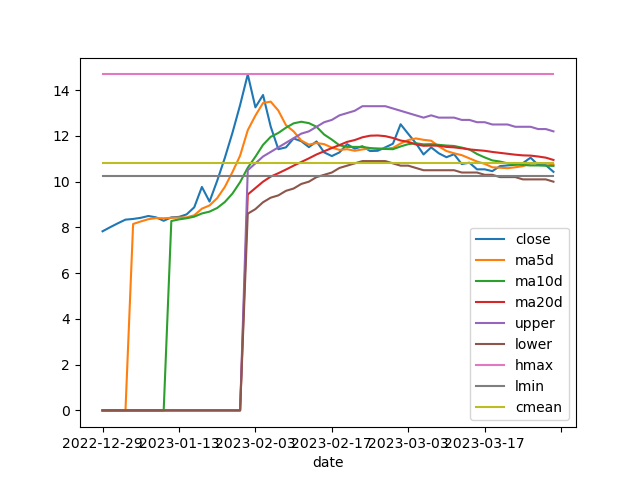

In [68]:
code
tdf = tdd.get_tdx_Exp_day_to_df(code, dl=60).sort_index(ascending=True)
cname = tdd.get_sina_data_code(code)
# plt.title(
#     stock_code + " | " + cname + " | " + str(quotes.index[-1])[: 10],
#     fontsize=14)
tdf.loc[:, ["close", "ma5d", "ma10d", "ma20d",
            "upper", "lower", "hmax", 'lmin', 'cmean']].plot()

In [69]:
tdf[tdf.columns[(tdf.columns >= "perc1d") & (tdf.columns <= "perc9d")]][-1:]

,perc1d,perc2d,perc3d,perc4d,perc5d,perc6d,perc7d,perc8d,perc9d
date,,,,,,,,,
2023-03-30,0.9,1.0,0.9,1.1,1.1,1.0,1.1,1.1,-0.1


In [70]:
tdf[tdf.columns[(tdf.columns >= "per1d") & (tdf.columns <= "per9d")]][-1:]

,per1d,per2d,per3d,per4d,per5d,per6d,per7d,per8d,per9d
date,,,,,,,,,
2023-03-30,-2.7,-0.1,-2.9,2.2,0.7,0.3,0.3,2.1,-0.8
